In [108]:
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import IterableDataset, Dataset

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer

import pandas as pd
import numpy as np
import json

import re
from termcolor import colored
from tqdm.auto import tqdm

from src.settings import POLISH_ANNOTATIONS_FPATH, EMBEDDINGS_DIR

tqdm.pandas()

In [2]:
pl_ann_df = pd.read_json(POLISH_ANNOTATIONS_FPATH, lines=True)
pl_ann_df

,start,end,text,doc_filepath,video_filename,task_label
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
...,...,...,...,...,...,...
40350,248960,250320,[uderzanie w coś],/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40351,279560,291400,Kot zobaczył w akwarium rybkę. Podszedł i dał ...,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40352,291400,347120,"Zjadłam, zjadłam.",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40353,347120,356440,"Zając biegnie, zobaczył wiszące pranie. Wskocz...",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13


## Metadata

In [3]:
records_wth_metadata = pl_ann_df[pl_ann_df['text'].str.contains(r'\[|\]', regex=True)].reset_index()
records_wth_metadata

,index,start,end,text,doc_filepath,video_filename,task_label
0,12238,40960,42880,"[Pozostali mówią:] Ej, był alarm, walili w drzwi.",/24/K08BF17-26_24_24_alarm.eaf,K08BF17-26.mp4,24
1,12853,42480,43760,"Głusi zastanawiają się, [co się dzieje].",/24/K03BF22-26_24_24_alarm.eaf,K03BF22-26.mp4,24
2,14427,127920,131600,"Dobra, inny [dzień], poczekaj, szacuję...",/07/K21AF01-16_07_07_calendar.eaf,K21AF01-16.mp4,7
3,23918,144520,145480,"A ten chłopiec z rowerem [mówi]: dobrze, dobrze.",/17/K08AF17-26_17_pears_17_pears_pears.eaf,K08AF17-26.mp4,17
4,25326,127000,130200,"[Charlie] kopie go, [mały] odskoczył, cofa się...",/17/K16BF15-26_17_kid_17_kid_chaplin.eaf,K16BF15-26.mp4,17
5,29863,13160,17920,"Oni [pies i chłopiec] wstali, zobaczyli, że ni...",/08/K32AF01-16_08_frog_08_frog_frog.eaf,K32AF01-16.mp4,8
6,39210,107200,112440,Wypluł wodę. Nabrał wody i wypluł. [Kot] oblan...,/13/K32AF01-16_13_13_comics.eaf,K32AF01-16.mp4,13
7,39629,0,6640,"Są dwie Myszki [Miki]: jedna jest duża, a drug...",/13/K09AF01-15_13_13_comics.eaf,K09AF01-15.mp4,13
8,39632,12000,16360,Ta duża Myszka [Miki] ma na głowie jabłko.,/13/K09AF01-15_13_13_comics.eaf,K09AF01-15.mp4,13
9,39648,146720,149320,Jest Myszka [Miki]. To kobieta.,/13/K09AF01-15_13_13_comics.eaf,K09AF01-15.mp4,13


In [4]:
records_wth_metadata.shape[0] / pl_ann_df.shape[0]

0.0002725808450006195

In [5]:
for meta_text in records_wth_metadata['text']:
    metadata_list = re.findall(r'\[.*?\]', meta_text)
    for metadata in metadata_list:
        meta_text = meta_text.replace(metadata, colored(metadata, 'yellow'))
    print(meta_text)

[Pozostali mówią:] Ej, był alarm, walili w drzwi.
Głusi zastanawiają się, [co się dzieje].
Dobra, inny [dzień], poczekaj, szacuję...
A ten chłopiec z rowerem [mówi]: dobrze, dobrze.
[Charlie] kopie go, [mały] odskoczył, cofa się, idzie.
Oni [pies i chłopiec] wstali, zobaczyli, że nie ma żaby, więc szukają.
Wypluł wodę. Nabrał wody i wypluł. [Kot] oblany wodą zrezygnował i poszedł.
Są dwie Myszki [Miki]: jedna jest duża, a druga mała.
Ta duża Myszka [Miki] ma na głowie jabłko.
Jest Myszka [Miki]. To kobieta.
[uderzanie w coś]


## Dataset

In [6]:
herbert_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
herbert = AutoModel.from_pretrained("allegro/herbert-base-cased").to("cuda:0")

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def get_herbert_embedding(text: str, emb_model=None, tokenizer=None, device: str = "cuda") -> np.ndarray:
    return emb_model(
        **tokenizer.encode_plus(text,
            padding='longest',
            add_special_tokens=True,
            return_tensors='pt'
        ).to(device)
    ).pooler_output.to("cpu").detach().numpy()[0]

get_herbert_embedding("Ala ma kota", emb_model=herbert, tokenizer=herbert_tokenizer,).shape

(768,)

In [9]:
dataset = pl_ann_df.copy().drop(columns=["start", "end", "doc_filepath", "video_filename"]) \
    # .sample(frac=0.2)

dataset["embedding"] = dataset["text"].progress_apply(get_herbert_embedding, args=(herbert, herbert_tokenizer,))

  0%|          | 0/40355 [00:00<?, ?it/s]

In [10]:
dataset["task_label"] = dataset["task_label"].astype("str")

In [11]:
dataset

,text,task_label,embedding
0,"Myślę, że mam inny pomysł, można?",15,"[-0.039401494, 0.04514404, -0.07359819, 0.9993..."
1,"Chyba ten znak mówi, że jak ktoś będzie spacer...",15,"[-0.041031707, 0.18905161, -0.24736977, 0.9991..."
2,Trzeba przejść łukiem obok leżącego i o tym zn...,15,"[-0.09941986, 0.25549677, -0.27581707, 0.99669..."
3,"Okrągły znak pomaga nam, mówi, że są pasy na u...",15,"[-0.2382573, -0.018337384, -0.060853552, 0.998..."
4,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",15,"[-0.12970468, 0.22667477, -0.3403942, 0.995259..."
...,...,...,...
40350,[uderzanie w coś],13,"[-0.18567152, 0.090941064, -0.07056465, 0.9985..."
40351,Kot zobaczył w akwarium rybkę. Podszedł i dał ...,13,"[-0.0069994903, -0.033343423, -0.19992347, 0.9..."
40352,"Zjadłam, zjadłam.",13,"[-0.002218116, 0.15197517, -0.0095876055, 0.99..."
40353,"Zając biegnie, zobaczył wiszące pranie. Wskocz...",13,"[0.04677121, -0.19330807, -0.19553015, 0.99709..."


In [12]:
dataset.isna().sum()

text          0
task_label    0
embedding     0
dtype: int64

In [14]:
def get_target_vec(label, mapping):
    vec = np.zeros(len(mapping))
    vec[mapping[label]] = 1
    return vec

dataset["target"] = dataset["task_label"].apply(get_target_vec, args=(label2id,))

In [15]:
dataset

,text,task_label,embedding,target
0,"Myślę, że mam inny pomysł, można?",15,"[-0.039401494, 0.04514404, -0.07359819, 0.9993...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,"Chyba ten znak mówi, że jak ktoś będzie spacer...",15,"[-0.041031707, 0.18905161, -0.24736977, 0.9991...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,Trzeba przejść łukiem obok leżącego i o tym zn...,15,"[-0.09941986, 0.25549677, -0.27581707, 0.99669...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,"Okrągły znak pomaga nam, mówi, że są pasy na u...",15,"[-0.2382573, -0.018337384, -0.060853552, 0.998...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",15,"[-0.12970468, 0.22667477, -0.3403942, 0.995259...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...
40350,[uderzanie w coś],13,"[-0.18567152, 0.090941064, -0.07056465, 0.9985...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
40351,Kot zobaczył w akwarium rybkę. Podszedł i dał ...,13,"[-0.0069994903, -0.033343423, -0.19992347, 0.9...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
40352,"Zjadłam, zjadłam.",13,"[-0.002218116, 0.15197517, -0.0095876055, 0.99...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
40353,"Zając biegnie, zobaczył wiszące pranie. Wskocz...",13,"[0.04677121, -0.19330807, -0.19553015, 0.99709...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [16]:
from sklearn.model_selection import train_test_split


train_df, val_df = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset["task_label"])

In [17]:
train_df.shape, val_df.shape

((32284, 4), (8071, 4))

In [18]:
# train_df.to_feather(EMBEDDINGS_DIR / "train_df_herbert_pl_task_clf.feather")
# val_df.to_feather(EMBEDDINGS_DIR / "val_df_herbert_pl_task_clf.feather")

In [109]:
train_df = pd.read_feather(EMBEDDINGS_DIR / "train_df_herbert_pl_task_clf.feather")
val_df = pd.read_feather(EMBEDDINGS_DIR / "val_df_herbert_pl_task_clf.feather")

In [110]:
id2label = {i: label for i, label in enumerate(pd.concat([train_df["task_label"], val_df["task_label"]]).unique())}
label2id = {label: i for i, label in id2label.items()}

id2label

{0: '24', 1: '15', 2: '17', 3: '13', 4: '7', 5: '8'}

In [116]:
class OrkpjmTaskDataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        return {
            "embedding": torch.from_numpy(self.df.iloc[index]["embedding"]),
            "target": torch.from_numpy(self.df.iloc[index]["target"])
        }

In [120]:
train_ds = OrkpjmTaskDataset(train_df, label2id)
val_ds = OrkpjmTaskDataset(val_df, label2id)

In [121]:
train_dl = DataLoader(train_ds, batch_size=32, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=32, pin_memory=True)

In [122]:
for batch in train_dl:
    print(batch["embedding"].shape)
    print(batch["target"].shape)
    break

torch.Size([32, 768])
torch.Size([32, 6])


## LSTM Classifier

In [214]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()

cuda:0


In [215]:
import torch.nn as nn

In [216]:
EMB_SIZE = 768

In [217]:
class LSTM_HerBERT(torch.nn.Module):
    def __init__(self, embedding_dim, num_labels, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(0.2)
        # self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        lstm_out, (ht, ct) = self.lstm(x)
        x = ht[-1]
        x = self.dropout(x)
        x = self.fc(x)
        # x = self.softmax(x)
        return x

In [218]:
# import torch.nn.functional as F
# from sklearn.metrics import mean_squared_error


# def train_model(model, epochs=10, lr=0.001):
#     parameters = filter(lambda p: p.requires_grad, model.parameters())
#     optimizer = torch.optim.Adam(parameters, lr=lr)
#     train_metrics = []
#     for i in range(epochs):
#         model.train()
#         sum_loss = 0.0
#         total = 0
#         for _, record in train_df.iterrows():
#             x = torch.tensor(np.array( [ record["embedding"] ] )).cuda()
#             y = torch.tensor(record["target"], requires_grad=True, dtype=torch.float).cuda()

#             y_pred = model(x)

#             optimizer.zero_grad()
#             loss = F.cross_entropy(y_pred, y)

#             loss.backward()
#             optimizer.step()

#             sum_loss += loss.item()*y.shape[0]
#             total += y.shape[0]

#         train_loss = sum_loss / total

#         val_loss, val_acc = validation_metrics(model)
#         train_metrics.append({
#             "train_loss": train_loss,
#             "val_loss": val_loss,
#             "val_acc": val_acc,
#         })

#         # if i == 0 or i == epochs - 1 or i % 5 == 0:
#         print(f"epoch: {i+1:<3} train loss {train_loss:.3f}, val loss {val_loss:.3f}, val accuracy {val_acc:.3f}")
#     return train_metrics


# def validation_metrics(model):
#     model.eval()
#     correct = 0
#     total = 0
#     sum_loss = 0.0
#     sum_rmse = 0.0
#     for _, record in val_df.iterrows():
#         x = torch.tensor( np.array([ record["embedding"]] ) ).cuda()
#         y = torch.tensor(record["target"], requires_grad=True, dtype=torch.float).cuda()

#         y_hat = model(x)

#         loss = F.cross_entropy(y_hat, y)

#         pred = torch.max(y_hat, dim=-1).indices.item()
#         # pred = torch.max(y_hat, 1)[1]

#         correct += (pred == y).float().sum()
#         total += y.shape[0]
#         sum_loss += loss.item()*y.shape[0]

#         # sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
#     # return sum_loss/total, correct/total, sum_rmse/total
#     return sum_loss/total, (correct/total).item()

In [219]:
# model = LSTM_HerBERT(
#     embedding_dim=EMB_SIZE,
#     num_labels=len(id2label),
#     hidden_dim=128
# ).cuda()

In [220]:
# train_metrics = train_model(model, epochs=30, lr=0.002)

epoch: 1   train loss 1.468, val loss 1.296, val accuracy 0.505
epoch: 2   train loss 1.363, val loss 1.255, val accuracy 0.456
epoch: 3   train loss 1.334, val loss 1.256, val accuracy 0.452
epoch: 4   train loss 1.306, val loss 1.207, val accuracy 0.441
epoch: 5   train loss 1.287, val loss 1.185, val accuracy 0.383
epoch: 6   train loss 1.277, val loss 1.204, val accuracy 0.364
epoch: 7   train loss 1.267, val loss 1.207, val accuracy 0.503
epoch: 8   train loss 1.261, val loss 1.185, val accuracy 0.339
epoch: 9   train loss 1.257, val loss 1.151, val accuracy 0.423
epoch: 10  train loss 1.248, val loss 1.144, val accuracy 0.369
epoch: 11  train loss 1.242, val loss 1.126, val accuracy 0.397
epoch: 12  train loss 1.237, val loss 1.130, val accuracy 0.375


KeyboardInterrupt: 

<Axes: >

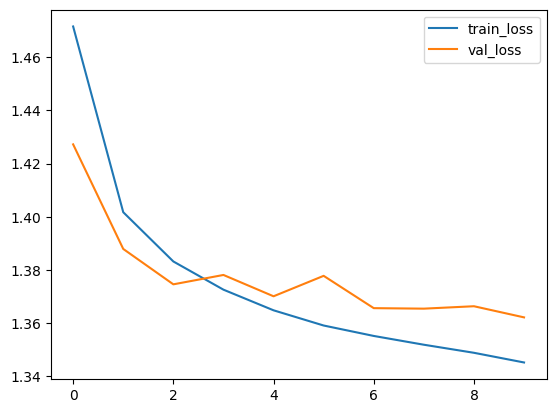

In [ ]:
metrics_df = pd.DataFrame.from_records(train_metrics)
metrics_df[["train_loss", "val_loss"]].plot()

<Axes: >

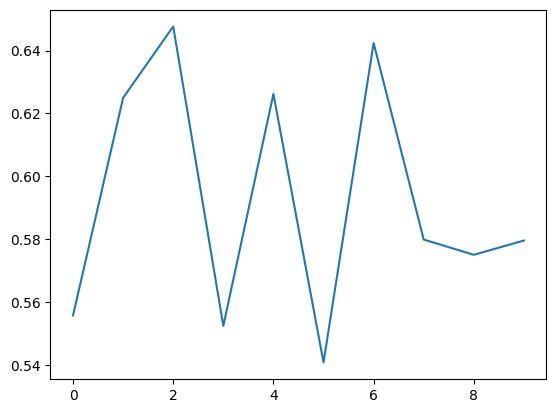

In [ ]:
metrics_df.val_acc.plot()